<h1 align="center"> Credit Fraud Detection </h1>


#### INTRODUCTION:
In this project, we'll apply 3 different predictive approaches to compare:
* How accurate we can be;
* How much we can minimize false positives (this becomes a problem when clients have their credit card blocked erroneously).

Since we can't see the real labels of each feature (for security reasons), we cannot infer additional business insights. Nevertheless, we can still deliver a good solution to this issue.


#### APPROACHES:
* Pycaret anomaly detection;
* Pycaret classifier (100% of our data);
* Classifier with under-over sample (using SMOTE technique).


#### GOALS:
* Implement models using pycaret modules to see how fast and accurate we can be with few code lines;
* Compare un-supervised models (anomaly detection) with supervised models (Logistic Regression);
* Implement a solution with under & over sample dataframe (using SMOTE technique).

In [1]:
# Standard Libraries
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Pycaret libraries
from pycaret.anomaly import *
# from pycaret.classification import * <- Will be imported when necessary
from pycaret.utils import enable_colab
enable_colab()


# Sklearn libraries
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression


# Other libraries
from imblearn.over_sampling import SMOTE
import seaborn as sns
from functools import reduce


# Change pandas columns limit
pd.set_option('display.max_columns', 100)

Colab mode enabled.


In [2]:
# Path
os.chdir('C:/Users/ttandozia/Desktop/KAGGLE_FRAUD')

In [3]:
# Dataset
df = pd.read_csv('creditcard.csv', sep=',')

In [4]:
# Scale features "Time" and "Amount"
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop original columns
df.drop(['Time','Amount'], axis=1, inplace=True)

# Reorder columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

#### We'll create the "original" train and test so we can compare the 3 approches with the same test set.

##### For each approach, we will split the data using random_state (or setion_id in pycaret) = 1313

In [5]:
# Spliting data
X = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=1313, shuffle=False)

for train_index, test_index in skf.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
original_df_train = pd.merge(original_Xtrain, original_ytrain, left_index=True, right_index=True)
original_df_test = pd.merge(original_Xtest, original_ytest, left_index=True, right_index=True)

# 1º APPROACH - ANOMALY DETECTION WITH PYCARET

In [6]:
# Pycaret Anomaly Setup
anom_setup = setup(data = original_df_train,
                   session_id=1313, # sklearn "random_state"
                   ignore_features=['Class'], 
                   preprocess=True,
                   imputation_type='iterative',
                   iterative_imputation_iters=30,
                   combine_rare_levels=True,
                   rare_level_threshold=0.01,
                   numeric_imputation='median')

,Description,Value
0,session_id,1313
1,Original Data,"(227846, 31)"
2,Missing Values,False
3,Numeric Features,30
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(227846, 30)"
9,CPU Jobs,-1


### ANOMALY MODELS:

**KNN**

In [7]:
# Creating model
t0 = time.time()
anom_model_knn = create_model('knn')
t1 = time.time()
print("Fitting knn took :{} sec".format(t1 - t0))

Fitting knn took :402.725647687912 sec


In [8]:
# Assign Label with data
anom_df_knn = assign_model(anom_model_knn)

In [9]:
# Check volumes
anom_df_knn['Anomaly'].value_counts()

0    216454
1     11392
Name: Anomaly, dtype: int64

In [10]:
# Crosstab wit target
pd.crosstab(anom_df_knn['Class'], anom_df_knn['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0,0,216376
1,0,1,11076
2,1,0,78
3,1,1,316


In [11]:
# Saving model
save_model(anom_df_knn, 'ANOM_KNN', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Class'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight...
 227865  0.488747 -0.063826 -0.610194  0.007487 -0.013918      0        0   
 227866  0.468036  0.571794 -0.403076  0.259078  0.077267      0        0   
 227867  0.700880 -0.769575 -0.193723  0.143983  0.134559      0        0   
 22786

**Isolation Forest**

In [12]:
# Creating model
t0 = time.time()
anom_model_ift = create_model('iforest')
t1 = time.time()
print("Fitting ift took :{} sec".format(t1 - t0))

Fitting ift took :23.881831884384155 sec


In [13]:
# Assign Label with data
anom_df_ift = assign_model(anom_model_ift)

In [14]:
# Check volumes
anom_df_ift['Anomaly'].value_counts()

0    216453
1     11393
Name: Anomaly, dtype: int64

In [15]:
# Crosstab wit target
pd.crosstab(anom_df_ift['Class'], anom_df_ift['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0,0,216400
1,0,1,11052
2,1,0,53
3,1,1,341


In [16]:
# Saving model
save_model(anom_df_ift, 'ANOM_IFT', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Class'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight...
 227865  0.488747 -0.063826 -0.610194  0.007487 -0.013918      0        0   
 227866  0.468036  0.571794 -0.403076  0.259078  0.077267      0        0   
 227867  0.700880 -0.769575 -0.193723  0.143983  0.134559      0        0   
 22786

**Clustering-Based Local Outlier**

In [17]:
# Creating model
t0 = time.time()
anom_model_clt = create_model('cluster')
t1 = time.time()
print("Fitting clt took :{} sec".format(t1 - t0))

Fitting clt took :20.332393646240234 sec


In [18]:
# Assign Label with data
anom_df_clt = assign_model(anom_model_clt)

In [19]:
# Check volumes
anom_df_clt['Anomaly'].value_counts()

0    216453
1     11393
Name: Anomaly, dtype: int64

In [20]:
# Crosstab wit target
pd.crosstab(anom_df_clt['Class'], anom_df_clt['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0,0,216407
1,0,1,11045
2,1,0,46
3,1,1,348


In [21]:
# Saving model
save_model(anom_df_clt, 'ANOM_CLT', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Class'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight...
 227865  0.488747 -0.063826 -0.610194  0.007487 -0.013918      0        0   
 227866  0.468036  0.571794 -0.403076  0.259078  0.077267      0        0   
 227867  0.700880 -0.769575 -0.193723  0.143983  0.134559      0        0   
 22786

**Histogram-based Outlier Detection**

In [22]:
# Creating model
t0 = time.time()
anom_model_his = create_model('histogram')
t1 = time.time()
print("Fitting his took :{} sec".format(t1 - t0))

Fitting his took :2.0970592498779297 sec


In [23]:
# Assign Label with data
anom_df_his = assign_model(anom_model_his)

In [24]:
# Check volumes
anom_df_his['Anomaly'].value_counts()

0    216453
1     11393
Name: Anomaly, dtype: int64

In [25]:
# Crosstab wit target
pd.crosstab(anom_df_his['Class'], anom_df_his['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0,0,216398
1,0,1,11054
2,1,0,55
3,1,1,339


In [26]:
# Saving model
save_model(anom_df_his, 'ANOM_HIS', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Class'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight...
 227865  0.488747 -0.063826 -0.610194  0.007487 -0.013918      0        0   
 227866  0.468036  0.571794 -0.403076  0.259078  0.077267      0        0   
 227867  0.700880 -0.769575 -0.193723  0.143983  0.134559      0        0   
 22786

**Principal Component Analysis**

In [27]:
# Creating model
t0 = time.time()
anom_model_pca = create_model('pca')
t1 = time.time()
print("Fitting pca took :{} sec".format(t1 - t0))

Fitting pca took :3.8145229816436768 sec


In [28]:
# Assign Label with data
anom_df_pca = assign_model(anom_model_pca)

In [29]:
# Check volumes
anom_df_pca['Anomaly'].value_counts()

0    216453
1     11393
Name: Anomaly, dtype: int64

In [30]:
# Crosstab wit target
pd.crosstab(anom_df_pca['Class'], anom_df_pca['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0,0,216407
1,0,1,11045
2,1,0,46
3,1,1,348


In [31]:
# Saving model
save_model(anom_df_pca, 'ANOM_PCA', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Class'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight...
 227866  0.468036  0.571794 -0.403076  0.259078  0.077267      0        0   
 227867  0.700880 -0.769575 -0.193723  0.143983  0.134559      0        0   
 227868  0.609969 -0.695184  0.463574  0.119990  0.134411      0        0   
 
    

**Minimum Covariance Determinant**

In [32]:
# Creating model
t0 = time.time()
anom_model_mcd = create_model('mcd')
t1 = time.time()
print("Fitting mcd took :{} sec".format(t1 - t0))

Fitting mcd took :142.09781455993652 sec


In [33]:
# Assign Label with data
anom_df_mcd = assign_model(anom_model_mcd)

In [34]:
# Check volumes
anom_df_mcd['Anomaly'].value_counts()

0    216453
1     11393
Name: Anomaly, dtype: int64

In [35]:
# Crosstab wit target
pd.crosstab(anom_df_mcd['Class'], anom_df_mcd['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0,0,216218
1,0,1,11234
2,1,0,235
3,1,1,159


In [36]:
# Saving model
save_model(anom_df_mcd, 'ANOM_MCD', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Class'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight...
 227865  0.488747 -0.063826 -0.610194  0.007487 -0.013918      0        0   
 227866  0.468036  0.571794 -0.403076  0.259078  0.077267      0        0   
 227867  0.700880 -0.769575 -0.193723  0.143983  0.134559      0        0   
 22786

In [37]:
# Sintetic information
KNN = pd.crosstab(anom_df_knn['Class'], anom_df_knn['Anomaly']).stack().reset_index(name='Freq')
KNN = KNN.rename(columns={'Freq': 'KNN'})

IFT = pd.crosstab(anom_df_ift['Class'], anom_df_ift['Anomaly']).stack().reset_index(name='Freq')
IFT = IFT.rename(columns={'Freq': 'IFT'})

CLT = pd.crosstab(anom_df_clt['Class'], anom_df_clt['Anomaly']).stack().reset_index(name='Freq')
CLT = CLT.rename(columns={'Freq': 'CLT'})

HIS = pd.crosstab(anom_df_his['Class'], anom_df_his['Anomaly']).stack().reset_index(name='Freq')
HIS = HIS.rename(columns={'Freq': 'HIS'})

PCA = pd.crosstab(anom_df_pca['Class'], anom_df_pca['Anomaly']).stack().reset_index(name='Freq')
PCA = PCA.rename(columns={'Freq': 'PCA'})

MCD = pd.crosstab(anom_df_mcd['Class'], anom_df_mcd['Anomaly']).stack().reset_index(name='Freq')
MCD = MCD.rename(columns={'Freq': 'MCD'})

In [38]:
# Merge train results
models_list = [KNN, IFT, CLT, HIS, PCA, MCD]
results = reduce(lambda  left,right: pd.merge(left,right, how='left'), models_list)
results.head()

,Class,Anomaly,KNN,IFT,CLT,HIS,PCA,MCD
0,0,0,216376,216400,216407,216398,216407,216218
1,0,1,11076,11052,11045,11054,11045,11234
2,1,0,78,53,46,55,46,235
3,1,1,316,341,348,339,348,159


#### Now we'll predict our anomalies in the test set

In [39]:
# Test dataframes
KNN_TEST = predict_model(model=anom_model_knn, data=original_df_test)
IFT_TEST = predict_model(model=anom_model_ift, data=original_df_test)
CLT_TEST = predict_model(model=anom_model_clt, data=original_df_test)
HIS_TEST = predict_model(model=anom_model_his, data=original_df_test)
PCA_TEST = predict_model(model=anom_model_pca, data=original_df_test)
MCD_TEST = predict_model(model=anom_model_mcd, data=original_df_test)

In [40]:
# Sintetic information of test dataframe
KNN = pd.crosstab(KNN_TEST['Class'], KNN_TEST['Anomaly']).stack().reset_index(name='Freq')
KNN = KNN.rename(columns={'Freq': 'KNN'})

IFT = pd.crosstab(IFT_TEST['Class'], IFT_TEST['Anomaly']).stack().reset_index(name='Freq')
IFT = IFT.rename(columns={'Freq': 'IFT'})

CLT = pd.crosstab(CLT_TEST['Class'], CLT_TEST['Anomaly']).stack().reset_index(name='Freq')
CLT = CLT.rename(columns={'Freq': 'CLT'})

HIS = pd.crosstab(HIS_TEST['Class'], HIS_TEST['Anomaly']).stack().reset_index(name='Freq')
HIS = HIS.rename(columns={'Freq': 'HIS'})

PCA = pd.crosstab(PCA_TEST['Class'], PCA_TEST['Anomaly']).stack().reset_index(name='Freq')
PCA = PCA.rename(columns={'Freq': 'PCA'})

MCD = pd.crosstab(MCD_TEST['Class'], MCD_TEST['Anomaly']).stack().reset_index(name='Freq')
MCD = MCD.rename(columns={'Freq': 'MCD'})

In [41]:
# Merge test results
models_list = [KNN, IFT, CLT, HIS, PCA, MCD]
results = reduce(lambda  left,right: pd.merge(left,right, how='left'), models_list)
results.head()

,Class,Anomaly,KNN,IFT,CLT,HIS,PCA,MCD
0,0,0,53755,53998,54206,53974,54041,54436
1,0,1,3108,2865,2657,2889,2822,2427
2,1,0,17,16,14,17,15,72
3,1,1,81,82,84,81,83,26


#### We can see that Clustering-Based Local Outlier "CLT" model had the best performance when alocating 5% of our training data as anomaly, and predicting in test set.

#### Note: Its development time was 95% less than knn, for example. (It took 20 sec. Knn took 402 sec.)


#### Let's see the best anomaly model metrics

In [42]:
# Fix formats
CLT_TEST['Anomaly'] = CLT_TEST['Anomaly'].astype(float)
CLT_TEST['Class'] = CLT_TEST['Class'].astype(float)

In [43]:
# Metrics
acc = accuracy_score(CLT_TEST['Class'], CLT_TEST['Anomaly'])
auc = roc_auc_score(CLT_TEST['Class'], CLT_TEST['Anomaly_Score'])
recall = recall_score(CLT_TEST['Class'], CLT_TEST['Anomaly'])
precision = precision_score(CLT_TEST['Class'], CLT_TEST['Anomaly'])
f1 = f1_score(CLT_TEST['Class'], CLT_TEST['Anomaly'])

In [44]:
# Visualize metrics
cols = ['Model','Accurary','AUC','Recall','Prec.','F1']
values = ['CLT',acc,auc,recall,precision,f1]
metrics_df = pd.DataFrame({tup[0]: [tup[1]] for tup in zip(cols, values)})
metrics_df

,Model,Accurary,AUC,Recall,Prec.,F1
0,CLT,0.953108,0.960965,0.857143,0.030646,0.059176


In [45]:
# See real target and predicted label
pd.crosstab(CLT_TEST['Class'], CLT_TEST['Anomaly']).stack().reset_index(name='Freq')

,Class,Anomaly,Freq
0,0.0,0.0,54206
1,0.0,1.0,2657
2,1.0,0.0,14
3,1.0,1.0,84


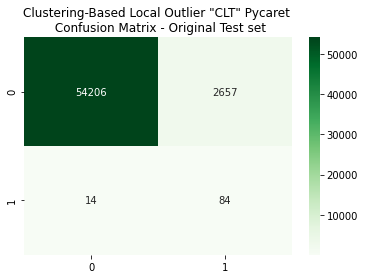

In [46]:
# Plot confusion matrix
conf_matx_anom = confusion_matrix(original_ytest, CLT_TEST['Anomaly'])
ax = plt.axes()
sns.heatmap(conf_matx_anom, annot=True, cmap='Greens', fmt='.0f')
ax.set_title('Clustering-Based Local Outlier "CLT" Pycaret \n Confusion Matrix - Original Test set')
plt.show()

# 2º APPROACH - CLASSIFIER WITH PYCARET

In [47]:
# Pycaret Classifier Setup

from pycaret.classification import *

ml_setup = setup(data = df,
                 target = 'Class',
                 session_id=1313,
                 feature_selection = True,
                 feature_selection_threshold=0.7,
                 fix_imbalance=True,
                 remove_multicollinearity = True,
                 multicollinearity_threshold = 0.4,
                 normalize=True,
                 normalize_method='robust',
                 remove_outliers=True,
                 train_size=0.8,
                 ignore_low_variance=True)

,Description,Value
0,session_id,1313
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(284807, 31)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [48]:
# Compare models
compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9998,0.6647,0.0200,0.1000,0.0333,0.0333,0.0446,149.3700
et,Extra Trees Classifier,0.9998,0.7653,0.0644,0.4000,0.1097,0.1096,0.1585,37.6760
xgboost,Extreme Gradient Boosting,0.9994,0.7042,0.1089,0.0580,0.0749,0.0747,0.0787,110.2380
catboost,CatBoost Classifier,0.9990,0.6903,0.0867,0.0278,0.0415,0.0412,0.0482,89.9040
lightgbm,Light Gradient Boosting Machine,0.9987,0.7534,0.1533,0.0303,0.0505,0.0502,0.0676,5.8600
dt,Decision Tree Classifier,0.9986,0.5094,0.0200,0.0033,0.0056,0.0053,0.0076,20.4940
knn,K Neighbors Classifier,0.9981,0.5966,0.1511,0.0174,0.0312,0.0308,0.0506,148.5900
gbc,Gradient Boosting Classifier,0.9725,0.7448,0.3489,0.0025,0.0050,0.0046,0.0276,246.3660
qda,Quadratic Discriminant Analysis,0.9550,0.6392,0.1956,0.0010,0.0019,0.0015,0.0108,1.6720
ada,Ada Boost Classifier,0.9463,0.7168,0.4378,0.0017,0.0034,0.0030,0.0244,49.2880


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1313, verbose=0,
                       warm_start=False)

#### We'll create a Logistic Regression since it has the best Recall and its Accuracy and AUC was acceptable

In [49]:
# Creating model
ml_model = create_model(estimator='lr',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8435,0.9437,0.8889,0.0012,0.0024,0.0019,0.0290
1,0.8715,0.7158,0.5556,0.0009,0.0018,0.0014,0.0184
2,0.8817,0.7319,0.4000,0.0008,0.0016,0.0011,0.0133
3,0.8886,0.7514,0.6667,0.0012,0.0025,0.0021,0.0254
4,0.8675,0.8893,0.8889,0.0014,0.0028,0.0024,0.0322
Mean,0.8706,0.8064,0.6800,0.0011,0.0022,0.0018,0.0237
SD,0.0154,0.0922,0.1904,0.0002,0.0005,0.0005,0.0069


In [50]:
# Predict
predict_model(ml_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8518,0.9754,0.9500,0.0111,0.0220,0.0186,0.0940


,V3,V8,V18,V27,V13,V7,V10,V5,scaled_amount,V22,...,V6,V4,V17,V12,V26,V24,V19,Class,Label,Score
0,0.556695,0.170458,0.372034,1.618953,0.356857,0.507318,-0.061292,0.363580,-0.270562,-0.570364,...,0.156699,-0.204154,-1.019310,0.408214,0.274932,-0.689930,0.664290,0,0,0.7776
1,0.377311,-0.081743,0.128819,0.520264,1.711790,-1.321332,1.302402,-1.190163,0.137313,-0.150241,...,0.369186,-0.805232,0.448631,-0.192312,-0.173484,-0.582664,0.232232,0,0,0.9412
2,-0.287048,-0.381197,0.167499,0.741556,-0.381046,0.864501,0.085946,0.877828,-0.283312,-0.534554,...,-0.231940,-0.455943,0.193363,0.202244,0.090866,0.692765,-0.073429,0,0,0.8046
3,0.419974,0.006018,0.492145,0.060495,1.141342,0.338917,-0.410922,0.829842,-0.028023,-0.090471,...,0.120044,-0.642437,-1.167792,0.676362,1.777833,-1.238375,1.144789,0,0,0.9482
4,-0.660386,-0.044080,0.121514,2.358651,0.634921,1.493415,-0.532053,-0.206764,3.320583,1.271759,...,0.066060,-0.210570,-0.363069,0.199861,-0.344192,0.869039,-0.022032,0,0,0.9739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56957,0.048762,1.510391,0.572402,-2.422383,-1.261917,-0.011089,-0.599377,-0.443520,0.741908,0.088100,...,-0.236730,-0.028853,-0.035232,-0.117854,0.581853,0.040530,0.622476,0,0,0.9999
56958,0.960143,1.793332,-0.354809,-0.455405,-0.148154,-0.351384,-0.863984,-0.158361,-0.238335,0.520486,...,1.090847,-0.003319,-0.017127,1.036218,-0.932526,-0.419910,-1.456023,0,0,0.9958
56959,-0.525572,0.335239,1.287645,0.163196,-0.142998,-0.493511,0.366743,-0.073525,1.933586,0.526179,...,0.874597,0.718788,-1.434715,0.212951,-0.754495,-1.810133,0.151892,0,0,0.7404
56960,0.944113,1.549350,0.477104,1.429708,-0.489745,-0.217013,-0.223748,-0.347772,-0.170660,0.110361,...,0.569636,0.428761,-0.013211,0.256718,-0.514763,-0.076103,0.319650,0,0,0.9660


#### The tune model will try to optimize the recall using hyperparameters

In [51]:
# Tune model
ml_model_tuned = tune_model(ml_model, fold=5,
                            optimize='Recall',
                            n_iter=30)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8435,0.9437,0.8889,0.0012,0.0024,0.0019,0.0290
1,0.8715,0.7168,0.5556,0.0009,0.0018,0.0014,0.0184
2,0.8816,0.7298,0.4000,0.0008,0.0016,0.0011,0.0133
3,0.8886,0.7520,0.6667,0.0012,0.0025,0.0021,0.0254
4,0.8675,0.8891,0.8889,0.0014,0.0028,0.0024,0.0321
Mean,0.8705,0.8063,0.6800,0.0011,0.0022,0.0018,0.0237
SD,0.0154,0.0923,0.1904,0.0002,0.0005,0.0005,0.0069


In [52]:
# Tune Predict
predictions = predict_model(ml_model_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8519,0.9754,0.9500,0.0111,0.0220,0.0186,0.0941


#### Even though the training had 68% Recall, when applied to the test set, not only the model was able to maintain the accuracy and AUC, but it improved the Recall significantly.

## Test set metrics:

In [53]:
# Evaluating
evaluate_model(ml_model_tuned)

,Parameters
C,3.872
class_weight,balanced
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


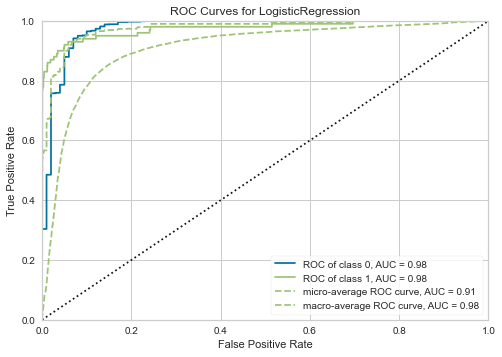

In [54]:
# AUC
plot_model(ml_model_tuned)

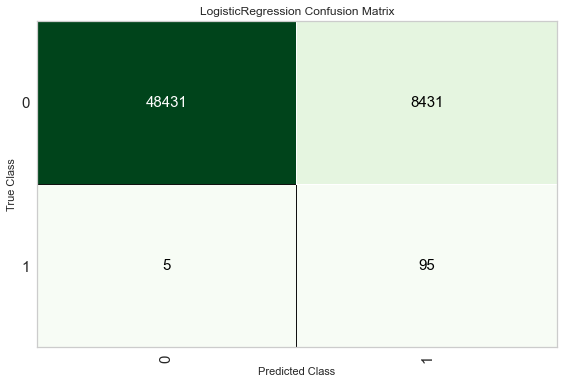

In [55]:
# Confusion matrix
plot_model(ml_model_tuned, plot='confusion_matrix')

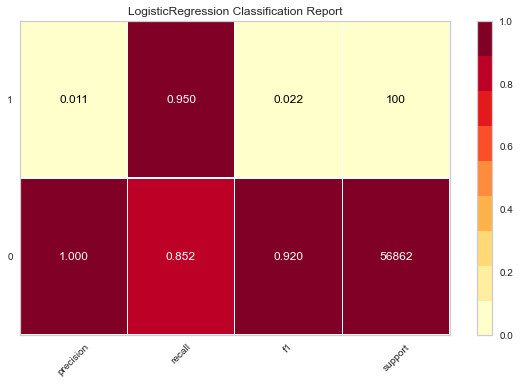

In [56]:
# Class report
plot_model(ml_model_tuned, plot='class_report')

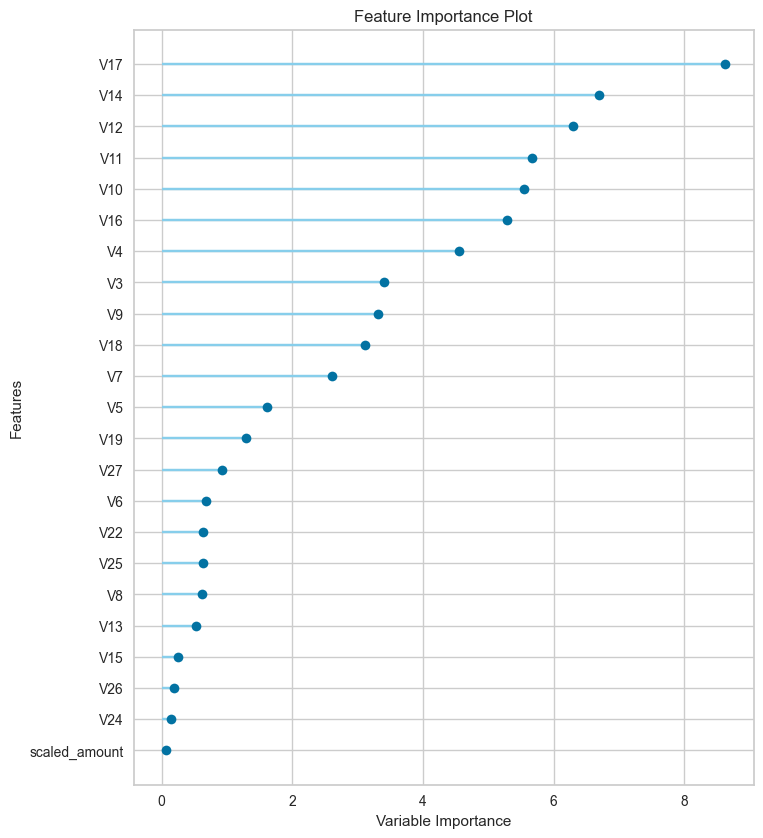

In [57]:
# Feature importance
plot_model(ml_model_tuned, plot='feature_all')

In [58]:
# Finalize model
final_ml_tuned = finalize_model(ml_model_tuned)

In [59]:
# Saving model
save_model(final_ml_tuned, 'LR_PYCARET')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                        target_variable='Class',
                                        threshold=0.4)),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegression(C=3.872, class_

In [60]:
# Fix formats
predictions['Label'] = predictions['Label'].astype(float)
predictions['Class'] = predictions['Class'].astype(float)

In [61]:
# Metrics
acc = accuracy_score(predictions['Class'], predictions['Label'])
auc = roc_auc_score(predictions['Class'], predictions['Score'])
recall = recall_score(predictions['Class'], predictions['Label'])
precision = precision_score(predictions['Class'], predictions['Label'])
f1 = f1_score(predictions['Class'], predictions['Label'])

In [62]:
# Visualize metrics
cols = ['Model','Accurary','AUC','Recall','Prec.','F1']
values = ['Random Forest',acc,auc,recall,precision,f1]
metrics_df = pd.DataFrame({tup[0]: [tup[1]] for tup in zip(cols, values)})
metrics_df

,Model,Accurary,AUC,Recall,Prec.,F1
0,Random Forest,0.851901,0.879819,0.95,0.011142,0.022026


In [63]:
# See real target and predicted label
pd.crosstab(predictions['Class'], predictions['Label']).stack().reset_index(name='Freq')

,Class,Label,Freq
0,0.0,0.0,48431
1,0.0,1.0,8431
2,1.0,0.0,5
3,1.0,1.0,95


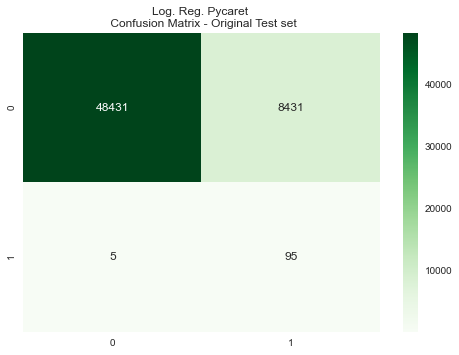

In [64]:
# Plot confusion matrix
conf_matx_clf = confusion_matrix(predictions['Class'], predictions['Label'])
ax = plt.axes()
sns.heatmap(conf_matx_clf, annot=True, cmap='Greens', fmt='.0f')
ax.set_title('Log. Reg. Pycaret \n Confusion Matrix - Original Test set')
plt.show()

# 3º APPROACH - CLASSIFIER WITH UNDER & OVER SAMPLES

#### We'll apply some techniques to help our model identify the outliers.


* First, we'll create a dataframe with 492 non-fraud observations and 492 fraud observations (all fraud available);
* Second, we'll use smote (over-sample) in this dataframe with 984 observations and create our model with these new data (smote after under-sampling);
* After that, we'll predict the under-sampled test set (984 observations);
* Finally, we'll predict the original test set with 56,961 observations.

In [65]:
# Shuffle the data before creating the subsamples

df = df.sample(frac=1)

# Fraud classes = 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=1313)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
151006,-0.293440,0.113606,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1
248419,2.019842,0.813520,1.939494,-1.228433,-1.822550,-1.123825,-0.153692,-0.232265,-0.295362,-0.198967,...,0.368968,0.548874,1.212058,-0.208544,0.172305,0.222485,0.043438,-0.071139,-0.046482,0
154670,1.145812,0.209084,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,...,1.264954,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,1
15566,1.089779,-0.678239,-23.237920,13.487386,-25.188773,6.261733,-17.345188,-4.534989,-17.100492,15.374630,...,1.630787,1.769708,-1.691973,-1.045673,0.143386,1.611577,-0.221576,1.481233,0.438125,1
33295,-0.293440,-0.558230,-0.615139,1.424862,0.825301,0.259156,0.738616,-1.222637,1.092297,-0.254737,...,-0.088241,0.091877,0.240611,-0.253740,0.286295,0.020606,-0.541818,0.001272,0.188636,0


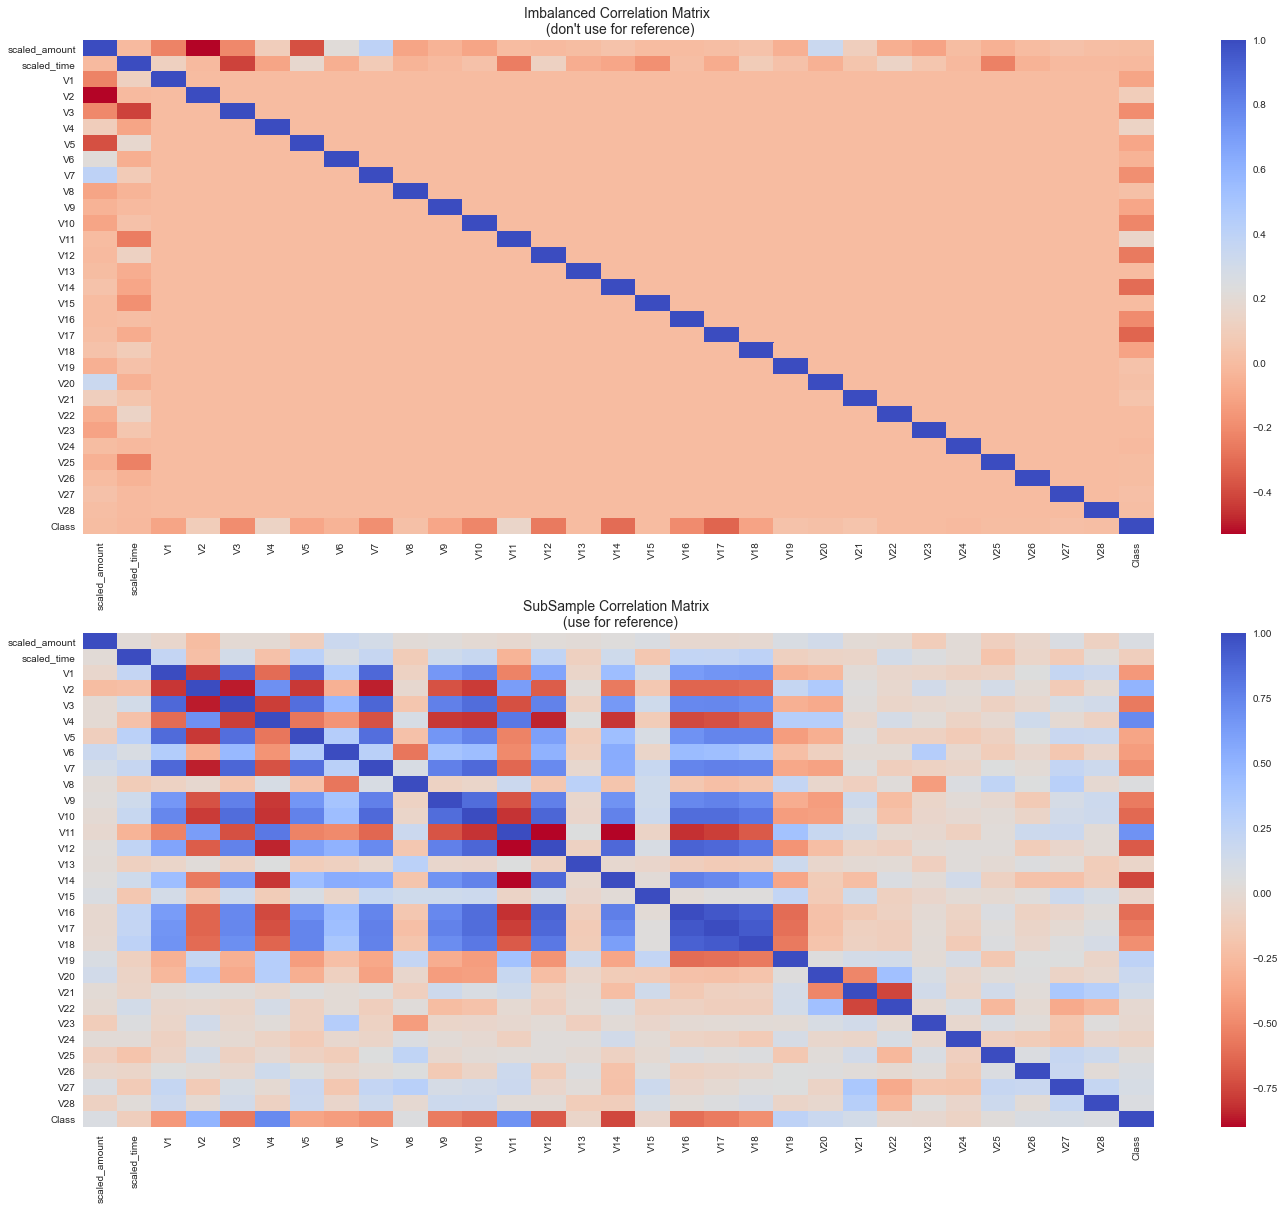

In [66]:
# Plot the original and the undersampled datasets to see the differences
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsample dataframe
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

#### We'll remove extreme outliers from features with high correlation with the class.

##### We'll use the interquartile range method, calculating the interquartile range (IQR) between the 75th percentile and the 25th percentile. This technique aims to define a threshold so if some instance passes it, it will be deleted.

In [67]:
# We will analyze only the 3 higher and the 3 lower correlations to remove extreme outlies
correlations = sub_sample_corr.drop(sub_sample_corr.columns.difference(['Class']), 1)
correlations = correlations.drop('Class', 0)
correlations = correlations.sort_values(by=['Class'])

In [68]:
# Lower
lower_3 = correlations[:3]

# Higher
higher_3 = correlations[-3:]

#### We could join the lower and higher correlations to apply only once. But, we'll keep separated so we can see the differences.

In [69]:
# Function to remove the extreme correlations
def extremeOutliers(df, correlations, cut):
    
    global new_df
    
    for row in correlations.index:
        var = row
        
        fraud_temp = df[var].loc[df['Class']==1].values
        q25, q75 = np.percentile(fraud_temp, 25), np.percentile(fraud_temp, 75)
        print('Feature: {}'.format(var))
        print('Quartile 25: {} | Quartile 75: {}'.format(round(q25,3), round(q75,3)))
        iqr_temp = q75 - q25
        print('iqr: {}'.format(round(iqr_temp,3)))

        cut_off_temp = iqr_temp * cut
        lower_temp, upper_temp = q25 - cut_off_temp, q75 + cut_off_temp
        print('Cut Off: {}'.format(round(cut_off_temp,3)))
        print('Lower: {}'.format(round(lower_temp,3)))
        print('Upper: {}'.format(round(upper_temp,3)))

        outliers = [x for x in fraud_temp if x < lower_temp or x > upper_temp]
        print('Feature Outliers for Fraud Cases: {}'.format(len(outliers)))
        print('outliers:{}'.format(outliers))
        
        print('----' * 30)

        df = df.drop(df[(df[var] > upper_temp) | (df[var] < lower_temp)].index)
        
    new_df = df
        
    return new_df

In [70]:
# Removing the lower correlations
extremeOutliers(new_df, lower_3, 1.5)

Feature: V14
Quartile 25: -9.693 | Quartile 75: -4.283
iqr: 5.41
Cut Off: 8.115
Lower: -17.808
Upper: 3.832
Feature Outliers for Fraud Cases: 4
outliers:[-18.8220867423816, -19.2143254902614, -18.4937733551053, -18.049997689859396]
------------------------------------------------------------------------------------------------------------------------
Feature: V12
Quartile 25: -8.673 | Quartile 75: -2.893
iqr: 5.78
Cut Off: 8.67
Lower: -17.343
Upper: 5.777
Feature Outliers for Fraud Cases: 4
outliers:[-18.4311310279993, -18.553697009645802, -18.047596570821604, -18.683714633344298]
------------------------------------------------------------------------------------------------------------------------
Feature: V10
Quartile 25: -7.467 | Quartile 75: -2.512
iqr: 4.955
Cut Off: 7.432
Lower: -14.899
Upper: 4.92
Feature Outliers for Fraud Cases: 27
outliers:[-22.1870885620007, -15.1237521803455, -15.2399619587112, -16.6496281595399, -18.9132433348732, -18.2711681738888, -15.2318333653018, -16

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
248419,2.019842,0.813520,1.939494,-1.228433,-1.822550,-1.123825,-0.153692,-0.232265,-0.295362,-0.198967,...,0.368968,0.548874,1.212058,-0.208544,0.172305,0.222485,0.043438,-0.071139,-0.046482,0
154670,1.145812,0.209084,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,...,1.264954,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,1
15566,1.089779,-0.678239,-23.237920,13.487386,-25.188773,6.261733,-17.345188,-4.534989,-17.100492,15.374630,...,1.630787,1.769708,-1.691973,-1.045673,0.143386,1.611577,-0.221576,1.481233,0.438125,1
33295,-0.293440,-0.558230,-0.615139,1.424862,0.825301,0.259156,0.738616,-1.222637,1.092297,-0.254737,...,-0.088241,0.091877,0.240611,-0.253740,0.286295,0.020606,-0.541818,0.001272,0.188636,0
239501,3.007895,0.768888,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,...,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117044,-0.269825,-0.119492,-0.641963,1.221503,1.285376,-0.024410,-0.160326,-0.635892,0.272910,-0.665436,...,-0.113711,0.552034,-0.880381,0.119209,0.443139,-0.232847,0.051465,0.271975,0.095299,0
224407,-0.097813,0.694146,2.345023,-1.421737,-1.447076,-1.896845,-0.648271,0.083851,-1.150088,-0.034705,...,-0.420608,-0.205623,-0.098950,0.057991,-1.471668,-0.041263,-0.088681,0.004239,-0.076750,0
8312,-0.293440,-0.864672,0.378275,3.914797,-5.726872,6.094141,1.698875,-2.807314,-0.591118,-0.123496,...,0.440439,0.149896,-0.601967,-0.613724,-0.403114,1.568445,0.521884,0.527938,0.411910,1
30442,-0.243695,-0.572916,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,...,0.757287,1.691042,0.920021,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,1


In [71]:
# Removing the higher correlations
extremeOutliers(new_df, higher_3, 1.5)

Feature: V2
Quartile 25: 1.133 | Quartile 75: 4.142
iqr: 3.009
Cut Off: 4.513
Lower: -3.38
Upper: 8.655
Feature Outliers for Fraud Cases: 46
outliers:[13.4873857909274, 9.067613427317669, 15.3658043803315, -3.95232008590575, 12.785970638297998, 12.785970638297998, 12.785970638297998, 12.9305051249875, 15.876922987953598, 10.5417508026636, -3.93073139597263, 10.114815724665402, 11.817921989785301, 12.6521968313004, -3.4204679837707, 10.5586001882538, -5.1983601992332895, 8.7759971528627, 10.8196653713117, -3.93591892431521, 16.1557014298057, 13.7659421584186, 16.4345245512223, 15.598192662555402, -6.976420007546411, -8.402153677689151, -7.15904171709445, 16.7133892350242, 14.6019980426299, 12.095893225929899, 9.66990017304097, 14.323253809723301, -7.4490151587267395, 12.3739891389716, 10.3939171427504, -4.8144607395562105, 12.785970638297998, 14.044566781510598, -7.19697963053735, 12.785970638297998, 12.785970638297998, 13.208904284417601, 11.586380519818402, 8.71325017095966, 9.2236919

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
248419,2.019842,0.813520,1.939494,-1.228433,-1.822550,-1.123825,-0.153692,-0.232265,-0.295362,-0.198967,...,0.368968,0.548874,1.212058,-0.208544,0.172305,0.222485,0.043438,-0.071139,-0.046482,0
154670,1.145812,0.209084,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,...,1.264954,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,1
33295,-0.293440,-0.558230,-0.615139,1.424862,0.825301,0.259156,0.738616,-1.222637,1.092297,-0.254737,...,-0.088241,0.091877,0.240611,-0.253740,0.286295,0.020606,-0.541818,0.001272,0.188636,0
239501,3.007895,0.768888,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,...,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1
191690,-0.307413,0.524900,1.183931,3.057250,-6.161997,5.543972,1.617041,-1.848006,-1.005508,0.339937,...,0.252571,0.109185,-0.931072,-0.064175,-0.007013,0.345419,0.064558,0.476629,0.323740,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117044,-0.269825,-0.119492,-0.641963,1.221503,1.285376,-0.024410,-0.160326,-0.635892,0.272910,-0.665436,...,-0.113711,0.552034,-0.880381,0.119209,0.443139,-0.232847,0.051465,0.271975,0.095299,0
224407,-0.097813,0.694146,2.345023,-1.421737,-1.447076,-1.896845,-0.648271,0.083851,-1.150088,-0.034705,...,-0.420608,-0.205623,-0.098950,0.057991,-1.471668,-0.041263,-0.088681,0.004239,-0.076750,0
8312,-0.293440,-0.864672,0.378275,3.914797,-5.726872,6.094141,1.698875,-2.807314,-0.591118,-0.123496,...,0.440439,0.149896,-0.601967,-0.613724,-0.403114,1.568445,0.521884,0.527938,0.411910,1
30442,-0.243695,-0.572916,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,...,0.757287,1.691042,0.920021,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,1


In [72]:
# Separating X and y
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Spliting train and test with the undersampled dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1313)

In [73]:
# SMOTE Technique (OverSampling)
sm = SMOTE(sampling_strategy='minority', random_state=1313)

In [74]:
# This is the data we will train the model
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [75]:
# Join X and y in the smote dataset
df_smote = pd.merge(Xsm_train, ysm_train, left_index=True, right_index=True)

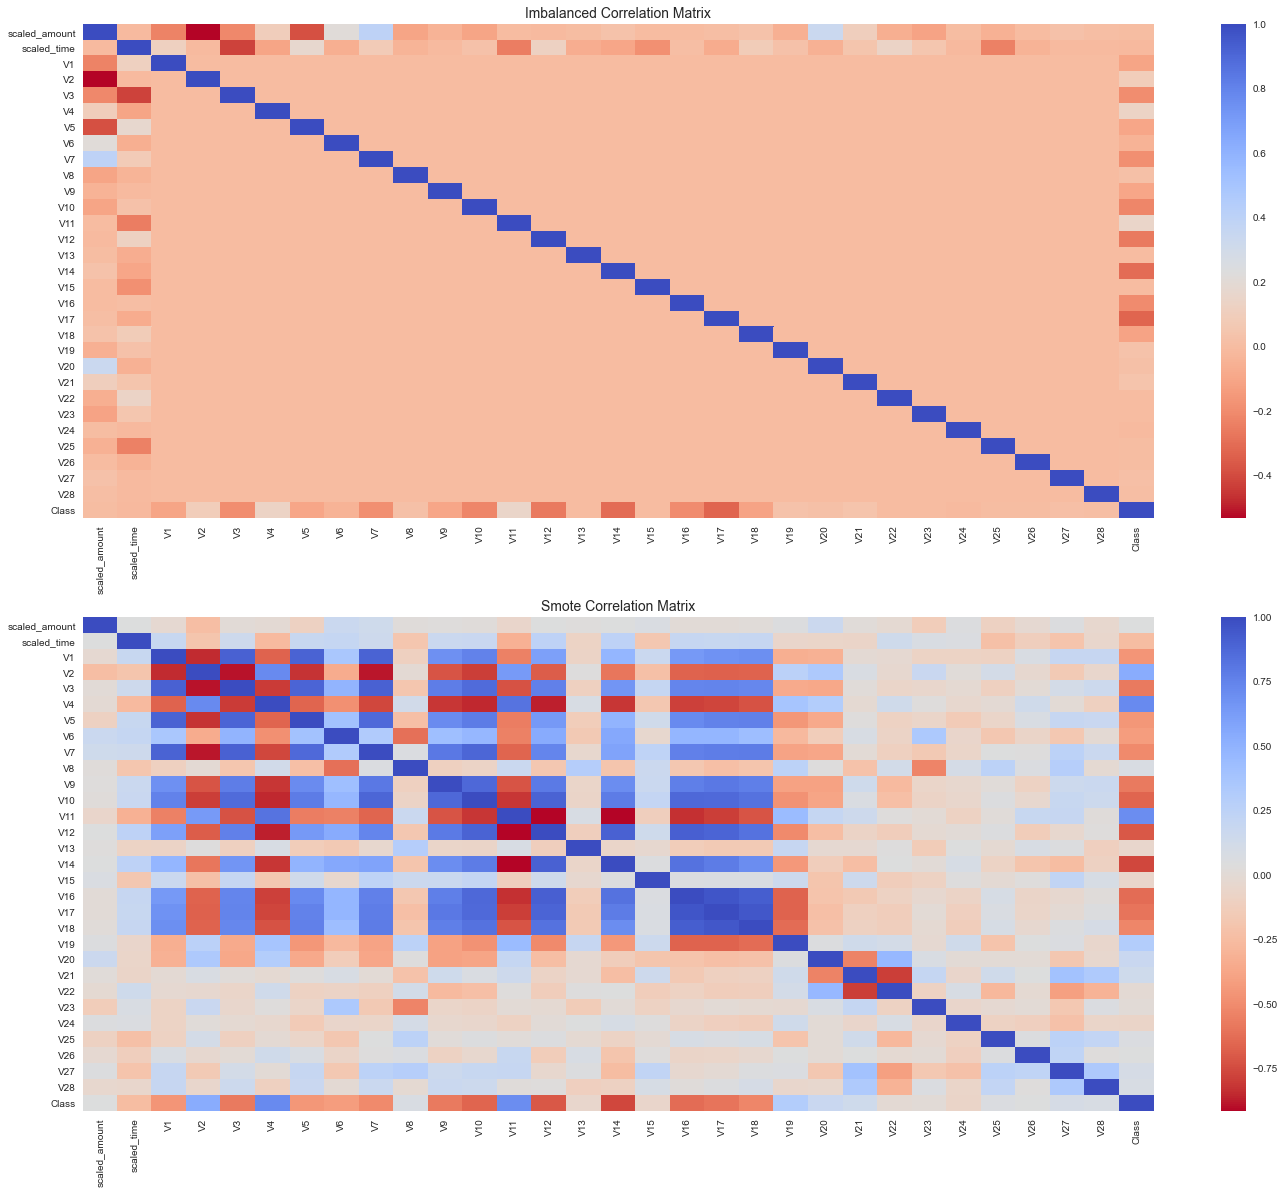

In [76]:
# Plot the original and the smote datasets to see the differences
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

# Smote dataFrame
sub_sample_corr = df_smote.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Smote Correlation Matrix', fontsize=14)
plt.show()

In [77]:
# We will analyze only the 3 higher and the 3 lower correlations to remove extreme outlies in the smote dataset
correlations = sub_sample_corr.drop(sub_sample_corr.columns.difference(['Class']), 1)
correlations = correlations.drop('Class', 0)
correlations = correlations.sort_values(by=['Class'])

In [78]:
# Lower (smote)
lower_3 = correlations[:3]

# Higher (smote)
higher_3 = correlations[-3:]

In [79]:
# Removing the lower correlations (smote)
extremeOutliers(df_smote, lower_3, 3)

Feature: V14
Quartile 25: -9.863 | Quartile 75: -4.542
iqr: 5.321
Cut Off: 15.963
Lower: -25.827
Upper: 11.421
Feature Outliers for Fraud Cases: 0
outliers:[]
------------------------------------------------------------------------------------------------------------------------
Feature: V12
Quartile 25: -9.809 | Quartile 75: -3.294
iqr: 6.515
Cut Off: 19.546
Lower: -29.355
Upper: 16.252
Feature Outliers for Fraud Cases: 0
outliers:[]
------------------------------------------------------------------------------------------------------------------------
Feature: V10
Quartile 25: -8.512 | Quartile 75: -2.91
iqr: 5.601
Cut Off: 16.804
Lower: -25.316
Upper: 13.894
Feature Outliers for Fraud Cases: 0
outliers:[]
------------------------------------------------------------------------------------------------------------------------


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454899,0.671712,0.108302,-12.307217,7.602335,-19.788195,7.189385,-11.061654,-4.867847,-14.707303,6.041148,...,-0.796822,2.003457,0.882080,-0.397793,0.469162,-0.130634,-0.189784,-2.151976,-0.666952,1
454900,-0.292028,-0.415486,0.624241,0.390222,0.974385,-0.045120,-0.225802,-0.500707,0.114670,-0.115106,...,-0.018109,0.033938,0.276856,-0.193575,-0.049123,0.459463,-0.465450,0.072489,0.028930,1
454901,-0.293440,-0.847775,-2.679379,7.022383,-13.548242,10.223529,-2.893169,-3.050300,-9.221104,3.323667,...,1.481529,1.878727,0.297881,0.232744,-1.186607,-0.560702,0.629879,1.930587,0.795589,1
454902,4.458440,-0.075704,-1.550026,-0.996501,0.810719,0.259955,-0.195255,-0.006302,1.082333,-0.000916,...,-0.176345,-0.057151,-0.235580,0.355842,-0.084267,0.095327,-0.571430,-0.061640,0.047448,1


In [80]:
# Removing the higher correlations (smote)
extremeOutliers(df_smote, higher_3, 3)

Feature: V2
Quartile 25: 1.328 | Quartile 75: 6.186
iqr: 4.858
Cut Off: 14.574
Lower: -13.245
Upper: 20.76
Feature Outliers for Fraud Cases: 522
outliers:[21.4672029942752, 22.0577289904909, 21.58361433063832, 21.988850878626053, 21.477239748906246, 21.905512688746356, 21.793438500680477, 21.582099744560637, 21.730665633383843, 21.20372471555416, 21.816294330605857, 21.491680761406492, 21.84003188924353, 20.97386125190294, 22.052719829116526, 21.347634785251575, 21.618596524417452, 21.546770870493475, 20.99338684963587, 21.415749552492965, 21.560575584225305, 21.060962005469456, 21.731172015153852, 21.938702340551508, 21.96480314439898, 21.532797320648122, 21.357857833850346, 21.58089093915473, 21.185296861703765, 20.99491021429548, 21.04782975130339, 21.70657221371062, 21.030098493071225, 21.74246242961703, 21.32169322403962, 21.57014748179804, 21.747112748864108, 21.71411424457876, 21.625782050534113, 20.764413052178707, 21.383524644229098, 21.582375026145396, 21.070782553898688, 21.

Feature: V11
Quartile 25: 2.365 | Quartile 75: 5.809
iqr: 3.444
Cut Off: 10.332
Lower: -7.967
Upper: 16.141
Feature Outliers for Fraud Cases: 0
outliers:[]
------------------------------------------------------------------------------------------------------------------------
Feature: V4
Quartile 25: 2.395 | Quartile 75: 6.423
iqr: 4.028
Cut Off: 12.084
Lower: -9.688
Upper: 18.507
Feature Outliers for Fraud Cases: 0
outliers:[]
------------------------------------------------------------------------------------------------------------------------


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454899,0.671712,0.108302,-12.307217,7.602335,-19.788195,7.189385,-11.061654,-4.867847,-14.707303,6.041148,...,-0.796822,2.003457,0.882080,-0.397793,0.469162,-0.130634,-0.189784,-2.151976,-0.666952,1
454900,-0.292028,-0.415486,0.624241,0.390222,0.974385,-0.045120,-0.225802,-0.500707,0.114670,-0.115106,...,-0.018109,0.033938,0.276856,-0.193575,-0.049123,0.459463,-0.465450,0.072489,0.028930,1
454901,-0.293440,-0.847775,-2.679379,7.022383,-13.548242,10.223529,-2.893169,-3.050300,-9.221104,3.323667,...,1.481529,1.878727,0.297881,0.232744,-1.186607,-0.560702,0.629879,1.930587,0.795589,1
454902,4.458440,-0.075704,-1.550026,-0.996501,0.810719,0.259955,-0.195255,-0.006302,1.082333,-0.000916,...,-0.176345,-0.057151,-0.235580,0.355842,-0.084267,0.095327,-0.571430,-0.061640,0.047448,1


In [81]:
# Separating X and y (smote)
X = df_smote.drop('Class', axis=1)
y = df_smote['Class']

# Spliting train and test (smote dataframe).
Xsm_train, X1_test, ysm_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=1313)

In [82]:
# Logistic Regression parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)

In [83]:
# Logistic Regression fitted in smote dataframe
t0 = time.time()
log_reg_sm = grid_log_reg.estimator
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting SMOTE data took :{} sec".format(t1 - t0))

Fitting SMOTE data took :6.92450475692749 sec


In [84]:
# Logistic Regression predicted in the under-sampled dataframe
y_pred_log_reg = log_reg_sm.predict(X_test)

In [85]:
# Report (comparing with under-sampled class)
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        94
           1       0.96      0.86      0.91        81

    accuracy                           0.92       175
   macro avg       0.93      0.92      0.92       175
weighted avg       0.92      0.92      0.92       175



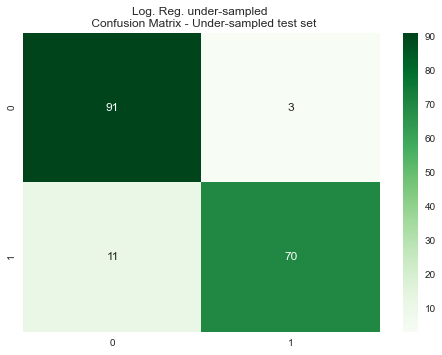

In [86]:
# Plot confusion matrix
conf_matx_smt = confusion_matrix(y_test, y_pred_log_reg)
ax = plt.axes()
sns.heatmap(conf_matx_smt, annot=True, cmap='Greens', fmt='.0f')
ax.set_title('Log. Reg. under-sampled \n Confusion Matrix - Under-sampled test set')
plt.show()

In [87]:
# Logistic Regression predicted in the original test set
y_pred_sm = log_reg_sm.predict(original_Xtest)

In [88]:
# Report
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, y_pred_sm, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.12      0.87      0.21        98

    accuracy                           0.99     56961
   macro avg       0.56      0.93      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [89]:
# Merge labels with X_test
original_Xtest['Label'] = y_pred_sm
original_Xtest['Class'] = original_ytest

In [90]:
# Metrics
acc = accuracy_score(original_Xtest['Class'], original_Xtest['Label'])
auc = roc_auc_score(original_Xtest['Class'], original_Xtest['Label'])
recall = recall_score(original_Xtest['Class'], original_Xtest['Label'])
precision = precision_score(original_Xtest['Class'], original_Xtest['Label'])
f1 = f1_score(original_Xtest['Class'], original_Xtest['Label'])

In [91]:
# Visualize metrics
cols = ['Model','Accurary','AUC','Recall','Prec.','F1']
values = ['Log. Reg. Smote',acc,auc,recall,precision,f1]
metrics_df = pd.DataFrame({tup[0]: [tup[1]] for tup in zip(cols, values)})
metrics_df

,Model,Accurary,AUC,Recall,Prec.,F1
0,Log. Reg. Smote,0.988905,0.928231,0.867347,0.120739,0.21197


In [92]:
# See real target and predicted label
pd.crosstab(original_Xtest['Class'], original_Xtest['Label']).stack().reset_index(name='Freq')

,Class,Label,Freq
0,0,0,56244
1,0,1,619
2,1,0,13
3,1,1,85


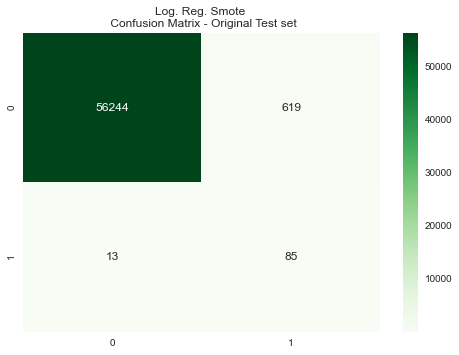

In [93]:
# Plot confusion matrix
conf_matx_smt = confusion_matrix(original_ytest, y_pred_sm)
ax = plt.axes()
sns.heatmap(conf_matx_smt, annot=True, cmap='Greens', fmt='.0f')
ax.set_title('Log. Reg. Smote \n Confusion Matrix - Original Test set')
plt.show()

# CONCLUSION

The implementations made in this project show us that we have a trade-off when it comes to models. On the one hand, a model that can detect 95% of anomaly cases, but which attributes a huge volume of "non-fraud" transactions to fraud (false positive). On the other hand, a little prediction is lost using an under-over sample model (we achieved 87% success in detecting fraud), but we labeled 92% less reputable transactions as fraud, thus reducing our volume of false positives.


**`Some points about the models:`**

* The model with under-over sample was the best. There were only 619 false-positive and 13 false-negative observations;
* The pycaret classification model was better at solving frauds, however, there were 8431 cases of false positives, which can generate dissatisfaction among customers for having their cards blocked due to suspected fraud;
* The pycaret anomaly model managed to detect fraud as well as the under-over sample model, but it also had a high number of false positives (2657).


**`Important to say:`** Pycaret is a powerful prediction tool because with few lines of code it is possible to develop a model with great metrics. For models where there are no metrics designed and/or that need a quick solution, albeit a palliative one, pycaret will surely exceed expectations.


**`Personal note:`** I have been using pycaret in work projects. A scenario where we have few resources and a lot of demand. We are gaining agility with projects that need a quick response (due to our industry) or new customers, where there are still no defined metrics/goals.

**`Here is a summary of the 3 confusion matrices applied on the same test set:`**

Text(0.5, 1.0, 'Log. Reg. Smote \n Confusion Matrix - Original Test set')

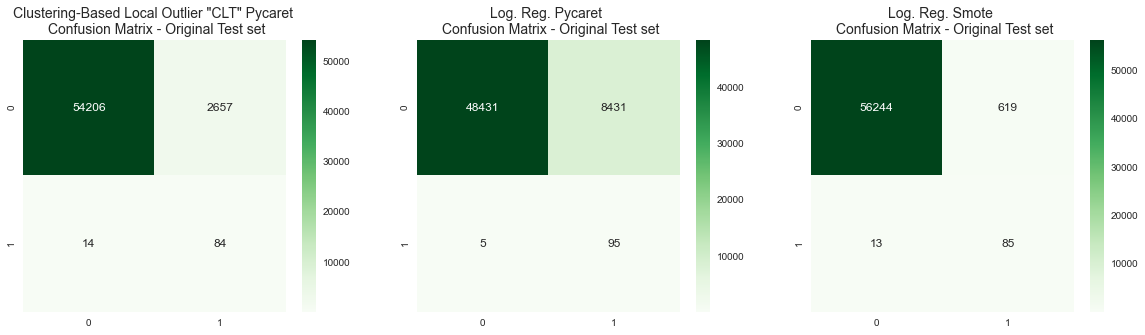

In [98]:
# Plot confusion matrix for the 3 approaches. Everyone built with the original test set

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# 1º Approach (Anomaly model with Pycaret)
sns.heatmap(conf_matx_anom, ax=ax1, annot=True, cmap='Greens', fmt='.0f')
ax1.set_title('Clustering-Based Local Outlier "CLT" Pycaret \n Confusion Matrix - Original Test set', fontsize=14)

# 2º Approach (Classifier model with Pycaret)
sns.heatmap(conf_matx_clf, ax=ax2, annot=True, cmap='Greens', fmt='.0f')
ax2.set_title('Log. Reg. Pycaret \n Confusion Matrix - Original Test set', fontsize=14)

# 3º Approach (Classifier with under & over sample)
sns.heatmap(conf_matx_smt, ax=ax3, annot=True, cmap='Greens', fmt='.0f')
ax3.set_title('Log. Reg. Smote \n Confusion Matrix - Original Test set', fontsize=14)